# Use Snowpark_OpenAI Notebook template

In [1]:
!!pip install "snowflake-connector-python[pandas]"

['Collecting snowflake-connector-python[pandas]',
 '  Using cached https://files.pythonhosted.org/packages/f8/c7/03d2ca5e460acb3a31d70ee17584fbc6fe828a52c9f83bbb20a392b8988b/snowflake_connector_python-3.7.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl',
 'Collecting requests<3.0.0',
 '  Using cached https://files.pythonhosted.org/packages/70/8e/0e2d847013cb52cd35b38c009bb167a1a26b2ce6cd6965bf26b47bc0bf44/requests-2.31.0-py3-none-any.whl',
 'Collecting asn1crypto<2.0.0,>0.24.0',
 '  Using cached https://files.pythonhosted.org/packages/c9/7f/09065fd9e27da0eda08b4d6897f1c13535066174cc023af248fc2a8d5e5a/asn1crypto-1.5.1-py2.py3-none-any.whl',
 'Collecting idna<4,>=2.5',
 '  Using cached https://files.pythonhosted.org/packages/c2/e7/a82b05cf63a603df6e68d59ae6a68bf5064484a0718ea5033660af4b54a9/idna-3.6-py3-none-any.whl',
 'Collecting certifi>=2017.4.17',
 '  Using cached https://files.pythonhosted.org/packages/ba/06/a07f096c664aeb9f01624f858c3add0a4e913d6c96257acb4fce61e7de14/cer

In [2]:
!pip install -q matplotlib seaborn xgboost

ERROR: snowflake-ml-python 1.0.10 has requirement packaging<24,>=20.9, but you'll have packaging 24.0 which is incompatible.
ERROR: snowflake-ml-python 1.0.10 has requirement pandas<2,>=1.0.0, but you'll have pandas 2.2.1 which is incompatible.
ERROR: snowflake-ml-python 1.0.10 has requirement xgboost<2,>=1.7.3, but you'll have xgboost 2.0.3 which is incompatible.
ERROR: jupyterlab 3.2.4 has requirement jupyter-server~=1.4, but you'll have jupyter-server 2.0.0a1 which is incompatible.
ERROR: jupyterlab-server 2.25.3 has requirement jsonschema>=4.18.0, but you'll have jsonschema 3.2.0 which is incompatible.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python
import matplotlib
import matplotlib.pyplot as plt # for plotting

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import datetime

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

# Read Customer and Payment data from Snowflake respective tables

In [2]:
#Import all snowflake connection details from template variables.

db_user = os.getenv('sf_user')
db_password =  'Password@2023' #os.getenv('sf_password')
db_account = os.getenv('sf_account')
db_database =  os.getenv('sf_db')
db_role = os.getenv('sf_role')
db_warehouse = 'FOSFOR_FDC'
db_schema = 'PUBLIC'

In [3]:
from snowflake.snowpark.session import Session
connection_params = {
    'user': db_user,
    'password': db_password,
    'account': db_account,
    'warehouse': db_warehouse,
    'database': db_database,
    'schema': db_schema,
    'role': db_role
}
session = Session.builder.configs(connection_params).create()

In [ ]:
session.sql('use warehouse FOSFOR_FDC;').collect()
session.sql('use database FDC_DATA_MANISH;').collect()
session.sql('use schema FDC_DATA_MANISH.PUBLIC;').collect()

cc_customer = session.table('FDC_DATA_MANISH.PUBLIC.CC_CUSTOMER_DATA').to_pandas()
cc_payment = session.table('FDC_DATA_MANISH.PUBLIC.CC_PAYMENT_DATA').to_pandas()

# Reverse Data Engineering to get Raw data

In [27]:
cc_customer['FEA_2'] = cc_customer['FEA_2'].replace([0],np.nan)

In [28]:
cc_payment['PROD_LIMIT'] = cc_payment['PROD_LIMIT'].replace([0],np.nan)
cc_payment['HIGHEST_BALANCE'] = cc_payment['HIGHEST_BALANCE'].replace([0],np.nan)

cc_payment['UPDATE_DATE'] = cc_payment['UPDATE_DATE'].replace(['31/12/9999'],np.nan)
cc_payment['REPORT_DATE'] = cc_payment['REPORT_DATE'].replace(['31/12/9999'],np.nan)

# Run Descriptive Statistics

In [29]:
print('Size of Custommer data', cc_customer.shape)
print('Size of Payment details', cc_payment.shape)

Size of Custommer data (1125, 13)
Size of Payment details (8250, 12)


In [30]:
cc_customer.head()

,LABEL,ID,FEA_1,FEA_2,FEA_3,FEA_4,FEA_5,FEA_6,FEA_7,FEA_8,FEA_9,FEA_10,FEA_11
0,1.0,54982665.0,5.0,1245.5,3.0,77000.0,2.0,15.0,5.0,109.0,5.0,151300.0,244.948974
1,0.0,54989781.0,4.0,1415.0,3.0,93000.0,2.0,8.0,5.0,113.0,4.0,151300.0,273.861279
2,0.0,58998054.0,4.0,1250.0,3.0,137000.0,2.0,8.0,5.0,90.0,5.0,72000.0,1.000000
3,0.0,58995381.0,7.0,1220.0,3.0,76000.0,2.0,11.0,2.0,90.0,5.0,71002.0,1.000000
4,0.0,58987926.0,5.0,NaN,2.0,50000.0,2.0,15.0,5.0,108.0,4.0,450000.0,169.000000


In [31]:
cc_payment.head()

,ID,OVD_T1,OVD_T2,OVD_T3,OVD_SUM,PAY_NORMAL,PROD_CODE,PROD_LIMIT,UPDATE_DATE,NEW_BALANCE,HIGHEST_BALANCE,REPORT_DATE
0,58987402,0,0,0,0,1,10,16500.0,04/12/2016,0.0,NaN,NaN
1,58995151,0,0,0,0,1,5,NaN,04/12/2016,588720.0,491100.0,NaN
2,58997200,0,0,0,0,2,5,NaN,04/12/2016,840000.0,700500.0,22/04/2016
3,54988608,0,0,0,0,3,10,37400.0,03/12/2016,8425.2,7520.0,25/04/2016
4,54987763,0,0,0,0,2,10,NaN,03/12/2016,15147.6,NaN,26/04/2016


In [32]:
cc_customer.describe(include='all')

,LABEL,ID,FEA_1,FEA_2,FEA_3,FEA_4,FEA_5,FEA_6,FEA_7,FEA_8,FEA_9,FEA_10,FEA_11
count,1125.000000,1.125000e+03,1125.000000,976.000000,1125.000000,1.125000e+03,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000,1125.000000
mean,0.200000,5.783677e+07,5.482667,1283.911373,2.333333,1.208836e+05,1.928889,10.872000,4.832889,100.802667,4.195556,164618.495111,134.999004
std,0.400178,1.817150e+06,1.383338,51.764022,0.878773,8.844523e+04,0.257125,2.676437,2.971182,11.988955,0.855679,152520.488281,112.616798
min,0.000000,5.498235e+07,1.000000,1116.500000,1.000000,1.500000e+04,1.000000,3.000000,-1.000000,64.000000,1.000000,60000.000000,1.000000
25%,0.000000,5.499050e+07,4.000000,1244.000000,1.000000,7.200000e+04,2.000000,8.000000,5.000000,90.000000,3.000000,60044.000000,1.000000
50%,0.000000,5.898975e+07,5.000000,1281.500000,3.000000,1.020000e+05,2.000000,11.000000,5.000000,105.000000,4.000000,72000.000000,173.205081
75%,0.000000,5.899799e+07,7.000000,1314.500000,3.000000,1.390000e+05,2.000000,11.000000,5.000000,111.000000,5.000000,151307.000000,202.484567
max,1.000000,5.900624e+07,7.000000,1481.000000,3.000000,1.200000e+06,2.000000,16.000000,10.000000,115.000000,5.000000,650070.000000,707.106781


In [33]:
cc_payment.describe(include='all')

,ID,OVD_T1,OVD_T2,OVD_T3,OVD_SUM,PAY_NORMAL,PROD_CODE,PROD_LIMIT,UPDATE_DATE,NEW_BALANCE,HIGHEST_BALANCE,REPORT_DATE
count,8.250000e+03,8250.000000,8250.000000,8250.000000,8250.000000,8250.000000,8250.000000,2132.000000,8224,8.250000e+03,7.841000e+03,7136
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3041,NaN,NaN,1862
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30/10/2012,NaN,NaN,21/09/2015
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,NaN,NaN,103
mean,5.782173e+07,0.249091,0.127152,0.369212,187.681697,14.526667,8.232000,85789.702205,NaN,1.054042e+05,2.192027e+05,NaN
std,1.822724e+06,1.250197,0.860046,2.900320,1804.232570,12.053627,3.533055,74345.828184,NaN,1.887704e+06,2.814536e+06,NaN
min,5.498235e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.100000,NaN,-4.030320e+04,5.010000e+02,NaN
25%,5.499050e+07,0.000000,0.000000,0.000000,0.000000,4.000000,6.000000,37400.000000,NaN,0.000000e+00,2.345300e+04,NaN
50%,5.898905e+07,0.000000,0.000000,0.000000,0.000000,11.000000,10.000000,68200.000000,NaN,0.000000e+00,4.404700e+04,NaN
75%,5.899655e+07,0.000000,0.000000,0.000000,0.000000,25.000000,10.000000,112200.000000,NaN,2.494800e+04,1.005000e+05,NaN


# Check Missing Value/data

In [34]:
# checking missing data
def get_missing_data(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    percent = round(percent,2)
    missing_df  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print( missing_df.head(20))
    return None

In [35]:
get_missing_data(cc_customer)

        Total  Percent
FEA_2     149    13.24
LABEL       0     0.00
ID          0     0.00
FEA_1       0     0.00
FEA_3       0     0.00
FEA_4       0     0.00
FEA_5       0     0.00
FEA_6       0     0.00
FEA_7       0     0.00
FEA_8       0     0.00
FEA_9       0     0.00
FEA_10      0     0.00
FEA_11      0     0.00


In [36]:
get_missing_data(cc_payment)

                 Total  Percent
PROD_LIMIT        6118    74.16
REPORT_DATE       1114    13.50
HIGHEST_BALANCE    409     4.96
UPDATE_DATE         26     0.32
OVD_T3               0     0.00
OVD_T2               0     0.00
OVD_T1               0     0.00
ID                   0     0.00
PROD_CODE            0     0.00
PAY_NORMAL           0     0.00
OVD_SUM              0     0.00
NEW_BALANCE          0     0.00


In [37]:
def data_profile(df):
    stats = []
    for col in df.columns:
        stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
    stats_df.sort_values('Percentage of missing values', ascending=True)
    return stats_df

In [38]:
data_profile(cc_customer)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
0,LABEL,2,0.000000,80.000000,float64
1,ID,1125,0.000000,0.088889,float64
2,FEA_1,6,0.000000,42.311111,float64
3,FEA_2,158,13.244444,13.244444,float64
4,FEA_3,3,0.000000,60.800000,float64
5,FEA_4,229,0.000000,3.022222,float64
6,FEA_5,2,0.000000,92.888889,float64
7,FEA_6,10,0.000000,41.333333,float64
8,FEA_7,10,0.000000,61.244444,float64
9,FEA_8,52,0.000000,8.711111,float64


In [39]:
data_profile(cc_payment)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
0,ID,1125,0.000000,0.666667,int32
1,OVD_T1,21,0.000000,90.606061,int8
2,OVD_T2,16,0.000000,95.587879,int8
3,OVD_T3,33,0.000000,96.763636,int8
4,OVD_SUM,393,0.000000,88.848485,int16
5,PAY_NORMAL,37,0.000000,11.030303,int8
6,PROD_CODE,21,0.000000,54.824242,int8
7,PROD_LIMIT,321,74.157576,74.157576,float64
8,UPDATE_DATE,3041,0.315152,0.315152,object
9,NEW_BALANCE,3939,0.000000,46.836364,float64


In [53]:
cc_customer['FEA_2'].head()

0    None
1    None
2    None
3    None
4    None
Name: FEA_2, dtype: object

In [42]:
cc_customer['FEA_2'].fillna(cc_customer['FEA_2'].mean(),inplace=True)

<ipython-input-42-7a4ac448dfff>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cc_customer['FEA_2'] = cc_customer['FEA_2'].fillna(cc_customer['FEA_2'].mean(),inplace=True)


In [41]:
cc_payment['HIGHEST_BALANCE'].fillna(0,inplace=True)

<ipython-input-41-b708c459c798>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cc_payment['HIGHEST_BALANCE'].fillna(0,inplace=True)


In [43]:
cc_payment_df_prd = cc_payment.groupby(['ID','PROD_CODE']).agg({'NEW_BALANCE':'mean'}).reset_index().rename(columns={'NEW_BALANCE':'NEW_BALANCE_AVG'})

In [44]:
cc_payment_df_prd = cc_payment_df_prd[['ID','PROD_CODE','NEW_BALANCE_AVG']].drop_duplicates(keep='first')
cust_pay_merge = pd.merge(cc_customer,cc_payment[['ID','PROD_CODE']],left_on=['ID'],right_on=['ID'],how='inner')

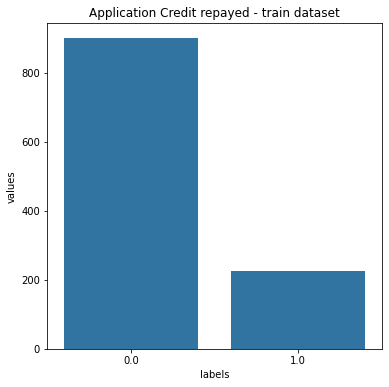

In [45]:
temp = cc_customer["LABEL"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
plt.figure(figsize = (6,6))
plt.title('Application Credit repayed - train dataset')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

In [46]:
cc_payment_df_prd

,ID,PROD_CODE,NEW_BALANCE_AVG
0,54982353,1,0.000
1,54982353,2,0.000
2,54982353,10,47287.275
3,54982356,6,0.000
4,54982356,10,7972.200
...,...,...,...
3051,59006193,10,16201.800
3052,59006219,5,528427.200
3053,59006219,10,5650.200
3054,59006239,6,0.000


In [47]:
# Plot distribution of multiple features, with TARGET = 1/0 on the same graph
def plot_distribution_comp(df,label,var,nrow=2):
    
    i = 0
    t1 = df.loc[df[label] != 0]
    t0 = df.loc[df[label] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="label = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="label = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

In [48]:
print('Minimum new balance avg in the dataset :- ',cc_payment_df_prd['NEW_BALANCE_AVG'].min())
print('Maximum new balance avg in the dataset :- ',cc_payment_df_prd['NEW_BALANCE_AVG'].max())

Minimum new balance avg in the dataset :-  -32662.8
Maximum new balance avg in the dataset :-  163211958.0


/tmp/pip_packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-49-0818ebce8124>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(cc_payment_df_prd['NEW_BALANCE_AVG']+1))


<Axes: xlabel='NEW_BALANCE_AVG', ylabel='Density'>

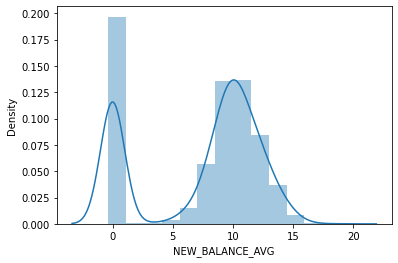

In [49]:
sns.distplot(np.log(cc_payment_df_prd['NEW_BALANCE_AVG']+1))

In [50]:
# Find correlations with the target and sort
correlations = cc_customer.corr()['LABEL'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 FEA_4    -1.314593e-01
ID       -2.461878e-02
FEA_8    -2.125122e-02
FEA_7    -1.227143e-02
FEA_9     1.869918e-16
FEA_10    8.808212e-04
FEA_11    2.444255e-03
FEA_5     1.729286e-02
FEA_6     2.890698e-02
FEA_1     5.207118e-02
FEA_3     5.565787e-02
LABEL     1.000000e+00
FEA_2              NaN
Name: LABEL, dtype: float64

Most Negative Correlations:
 FEA_4    -1.314593e-01
ID       -2.461878e-02
FEA_8    -2.125122e-02
FEA_7    -1.227143e-02
FEA_9     1.869918e-16
FEA_10    8.808212e-04
FEA_11    2.444255e-03
FEA_5     1.729286e-02
FEA_6     2.890698e-02
FEA_1     5.207118e-02
FEA_3     5.565787e-02
LABEL     1.000000e+00
FEA_2              NaN
Name: LABEL, dtype: float64
